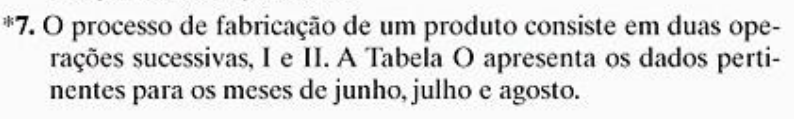
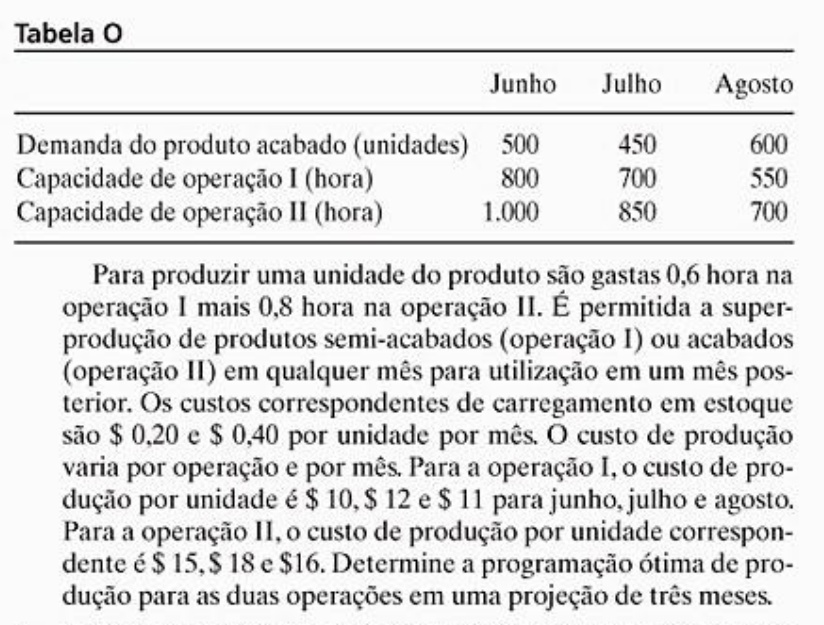

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Producao_Duas_Operacoes')

In [3]:
# --- Parâmetros extraídos do enunciado ---

# Períodos de tempo e estágios de produção
meses = ['junho', 'julho', 'agosto']
operacoes = [1, 2]

# Demanda final mensal (unidades de produto acabado)
demanda_final = {'junho': 500, 'julho': 450, 'agosto': 600}

# Capacidade mensal (horas) para cada operação
capacidade_horas = {
    1: {'junho': 800, 'julho': 700, 'agosto': 550},
    2: {'junho': 1000, 'julho': 850, 'agosto': 700}
}

# Tempo de produção (horas por unidade)
horas_por_unidade = {1: 0.6, 2: 0.8}

# Custos de produção ($ por unidade)
custo_producao = {
    1: {'junho': 10, 'julho': 12, 'agosto': 11},
    2: {'junho': 15, 'julho': 18, 'agosto': 16}
}

# Custos de estoque ($ por unidade por mês)
custo_estoque = {'semiacabado': 0.20, 'acabado': 0.40}

In [4]:
# 1. Variáveis de Decisão
# Quantidade produzida em cada operação, em cada mês
producao = model.continuous_var_matrix(operacoes, meses, name='P')

# Estoque de produtos semi-acabados (após Op I) no final de cada mês
estoque_semiacabado = model.continuous_var_dict(meses, name='E1', lb=0)

# Estoque de produtos acabados (após Op II) no final de cada mês
estoque_acabado = model.continuous_var_dict(meses, name='E2', lb=0)


# 2. Função Objetivo
# Minimizar o custo total (Produção Op I + Produção Op II + Estoque Semiacabado + Estoque Acabado)
expressao_custo_prod = (custo_producao[op][m] * producao[op,m] for op in operacoes for m in meses)
soma_custo_prod = model.sum(expressao_custo_prod)

expressao_custo_est_semi = (custo_estoque['semiacabado'] * estoque_semiacabado[m] for m in meses)
soma_custo_est_semi = model.sum(expressao_custo_est_semi)

expressao_custo_est_acabado = (custo_estoque['acabado'] * estoque_acabado[m] for m in meses)
soma_custo_est_acabado = model.sum(expressao_custo_est_acabado)

custo_total = soma_custo_prod + soma_custo_est_semi + soma_custo_est_acabado
model.minimize(custo_total)


# 3. Restrições

# Restrição 1: Capacidade de Produção
for op in operacoes:
    for m in meses:
        horas_usadas = horas_por_unidade[op] * producao[op,m]
        restr_capacidade_logica = horas_usadas <= capacidade_horas[op][m]
        model.add_constraint(restr_capacidade_logica, ctname=f'capacidade_op{op}_{m}')

# Restrição 2: Balanço de Estoque de Semiacabados
# Estoque_Inicial + Produção_Op1 - Consumo_Op2(Produção_Op2) = Estoque_Final
for idx, m in enumerate(meses):
    est_inicial = estoque_semiacabado[meses[idx-1]] if idx > 0 else 0
    restr_balanco_semi_logica = est_inicial + producao[1,m] - producao[2,m] == estoque_semiacabado[m]
    model.add_constraint(restr_balanco_semi_logica, ctname=f'balanco_semi_{m}')

# Restrição 3: Balanço de Estoque de Acabados
# Estoque_Inicial + Produção_Op2 - Demanda_Final = Estoque_Final
for idx, m in enumerate(meses):
    est_inicial = estoque_acabado[meses[idx-1]] if idx > 0 else 0
    restr_balanco_acab_logica = est_inicial + producao[2,m] - demanda_final[m] == estoque_acabado[m]
    model.add_constraint(restr_balanco_acab_logica, ctname=f'balanco_acab_{m}')

In [5]:
# Define um tempo limite para o solver (opcional)
model.parameters.timelimit = 120

# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
if solucao:
    custo_minimo = model.objective_value
    print(f"Custo Total Mínimo: ${custo_minimo:,.2f}\n")

    print("--- Plano de Produção (unidades por mês) ---")
    for m in meses:
        print(f"Mês de {m.capitalize()}:")
        for op in operacoes:
            prod_val = producao[op,m].solution_value
            if prod_val > 1e-6:
                print(f"  - Operação {op}: {prod_val:,.2f} unidades")

    print("\n--- Níveis de Estoque (unidades no final do mês) ---")
    print("Estoque de Semiacabados:")
    for m in meses:
        est_val = estoque_semiacabado[m].solution_value
        print(f"  - Final de {m.capitalize()}: {est_val:,.2f} unidades")
    print("Estoque de Acabados:")
    for m in meses:
        est_val = estoque_acabado[m].solution_value
        print(f"  - Final de {m.capitalize()}: {est_val:,.2f} unidades")
else:
    print("Não foi possível encontrar uma solução.")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               120
Tried aggregator 1 time.
LP Presolve eliminated 6 rows and 0 columns.
Aggregator did 1 substitutions.
Reduced LP has 5 rows, 11 columns, and 17 nonzeros.
Presolve time = 0.00 sec. (0.01 ticks)

Iteration log . . .
Iteration:     1   Dual objective     =          7740.000000

------ SOLUÇÃO ÓTIMA ------

Custo Total Mínimo: $39,720.00

--- Plano de Produção (unidades por mês) ---
Mês de Junho:
  - Operação 1: 1,333.33 unidades
  - Operação 2: 1,250.00 unidades
Mês de Julho:
Mês de Agosto:
  - Operação 1: 216.67 unidades
  - Operação 2: 300.00 unidades

--- Níveis de Estoque (unidades no final do mês) ---
Estoque de Semiacabados:
  - Final de Junho: 83.33 unidades
  - Final de Julho: 83.33 unidades
  - Final de Agosto: 0.00 unidades
Estoque de Acabados:
  - Final de Junho: 750.00 unidades
  - Final de Jul